In [1]:
import torch
import numpy as np 
import scipy.stats as ss 
import matplotlib.pylab as plt 
from scipy.optimize import minimize
from torch.distributions.multivariate_normal import MultivariateNormal

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

In [2]:
param1 = [-1.0, 4.0]
param2 = [4.0, 0.75] # [-1.0, 4.0, 0.1] # [-1.0, 4.0] # 
nparam1 = len(param1)
nparam2 = len(param2)
priorwidth = 10.0
priorcov1 = np.eye(nparam1) * priorwidth**2
priorcov2 = np.eye(nparam2) * priorwidth**2

minx = 0.0 
maxx = np.pi 
ndata = 100
domain = np.linspace(minx, maxx, ndata)
grad1 =  np.vstack([domain**2, domain]).T
# grad2 = np.vstack([domain**3, domain, np.ones(ndata)]).T

gradient_param_0 = np.sin(param2[1] * domain)
gradient_param_1 = param2[0] * domain * np.cos(param2[1] * domain)
grad2 = np.vstack([gradient_param_0, gradient_param_1]).T
         
sigma = 0.20
noise_cov = np.diag(np.ones(ndata)*sigma**2)

In [3]:
def model_1(param, domain):
    return param[0]*domain**2 + param[1]*domain

def model_2(param, domain):
    return param[0] * np.sin(param[1]*domain) # param[0]*domain**3 + param[1]*domain + param[2] #  

In [4]:
mu_fid_1 = model_1(param1, domain)
mu_fid_2 = model_2(param2, domain)
data = mu_fid_1 + sigma*np.random.randn(ndata)

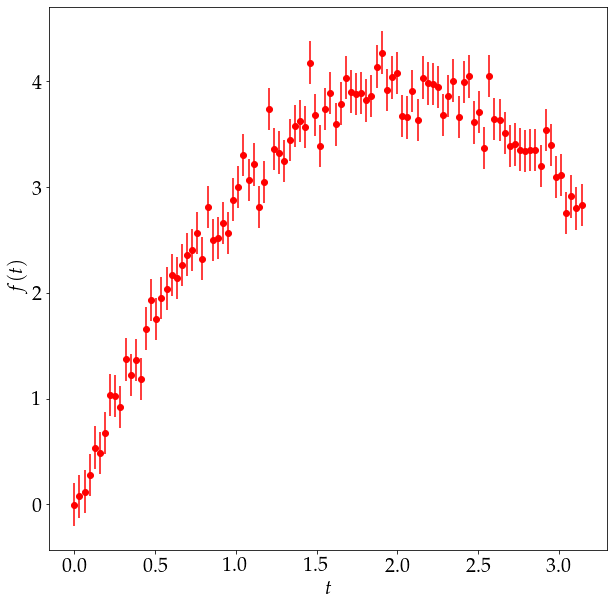

In [5]:
plt.figure(figsize = (10, 10))
plt.errorbar(domain, data, yerr=sigma, fmt = 'ro')
plt.ylabel(r'$f(t)$', fontsize = fontSize)
plt.xlabel(r'$t$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

In [6]:
def log_likelihood(parameters, data, domain, covariance, option=1):
    if option == 1:
        theory = model_1(parameters, domain)
    else:
        theory = model_2(parameters, domain)
    diff = data - theory 
    return -0.5*diff @ np.linalg.inv(covariance) @ diff

nll = lambda *args: -log_likelihood(*args)

In [7]:
# convert numpy to torch tensor
nt = lambda *array: torch.from_numpy(*array)

In [8]:
soln_1 = minimize(nll, param1, args=(data, domain, noise_cov, 1))
soln_2 = minimize(nll, param2, args=(data, domain, noise_cov, 2))

In [9]:
soln_1.x

array([-0.96242879,  3.90583637])

In [10]:
soln_2.x

array([4.0677017 , 0.77616071])

In [11]:
mu_fid_1 = model_1(soln_1.x, domain)
mu_fid_2 = model_2(soln_2.x, domain)

### Full Data

In [12]:
covdata1 = noise_cov + grad1 @ priorcov1 @ grad1.T
covdata2 = noise_cov + grad2 @ priorcov2 @ grad2.T

In [13]:
# to replace with torch
evi1 = ss.multivariate_normal(mu_fid_1, covdata1)
evi2 = ss.multivariate_normal(mu_fid_2, covdata2)

In [14]:
evi1.logpdf(data)

19.662315363886172

In [15]:
evi2.logpdf(data)

2.4479544025140214

In [16]:
evi1.logpdf(data) - evi2.logpdf(data)

17.21436096137215

### Extended Matrices (Alan's Implementation)

In [17]:
nparam_tot = nparam1 + nparam2

In [18]:
b1_mat = np.linalg.inv(noise_cov) @ grad1
b2_mat = np.linalg.inv(noise_cov) @ grad2

In [19]:
b_mat_ex = np.concatenate([b1_mat, b2_mat], axis = 1)
lam_ex = b_mat_ex.T @ noise_cov @ b_mat_ex

In [20]:
lam_1_ex = lam_ex + b_mat_ex.T @ grad1 @ priorcov1 @ grad1.T @ b_mat_ex
lam_2_ex = lam_ex + b_mat_ex.T @ grad2 @ priorcov2 @ grad2.T @ b_mat_ex

In [21]:
ystar1 = np.concatenate([b1_mat.T @ (mu_fid_1-mu_fid_1), b2_mat.T @ (mu_fid_1-mu_fid_2)])
ystar2 = np.concatenate([b1_mat.T @ (mu_fid_2-mu_fid_1), b2_mat.T @ (mu_fid_2-mu_fid_2)])

In [22]:
jitter = 1E-3
mu1 = torch.from_numpy(ystar1) 
mu2 = torch.from_numpy(ystar2)
cov1 = nt(lam_1_ex + jitter * np.eye(nparam_tot))
cov2 = nt(lam_2_ex + jitter * np.eye(nparam_tot))

ex_comp_evi1 = MultivariateNormal(mu1, cov1)
ex_comp_evi2 = MultivariateNormal(mu2, cov2)

In [23]:
ycomp1 = b1_mat.T @ (data - mu_fid_1)
ycomp2 = b2_mat.T @ (data - mu_fid_2) 
ycomp = np.concatenate([ycomp1, ycomp2])

In [24]:
ex_comp_evi1.log_prob(nt(ycomp))

tensor(-27.8172, dtype=torch.float64)

In [25]:
ex_comp_evi2.log_prob(nt(ycomp))

tensor(-45.0092, dtype=torch.float64)

In [26]:
ex_comp_evi1.log_prob(nt(ycomp)) - ex_comp_evi2.log_prob(nt(ycomp))

tensor(17.1920, dtype=torch.float64)

# Repetitions

In [27]:
record_full = list()
record_comp = list()
record_comp_alan = list()
evi_1_full = list()
evi_2_full = list()
evi_1_comp_alan = list()
evi_2_comp_alan = list()
ntrials = 50000

for i in range(ntrials):
    data = mu_fid_1 + sigma*np.random.randn(ndata)

    ycomp1 = b1_mat.T @ (data - mu_fid_1)
    ycomp2 = b2_mat.T @ (data - mu_fid_2) 
    ex_ycomp = np.concatenate([ycomp1, ycomp2])

    evi_1 = evi1.logpdf(data)
    evi_2 = evi2.logpdf(data)
    
    evi_c_a_1 = ex_comp_evi1.log_prob(nt(ex_ycomp))
    evi_c_a_2 = ex_comp_evi2.log_prob(nt(ex_ycomp))

    evi_1_full.append(evi_1)
    evi_2_full.append(evi_2)

    evi_1_comp_alan.append(evi_c_a_1)
    evi_2_comp_alan.append(evi_c_a_2)
    
    record_full.append(evi_1 - evi_2)
    record_comp_alan.append(evi_c_a_1 - evi_c_a_2)

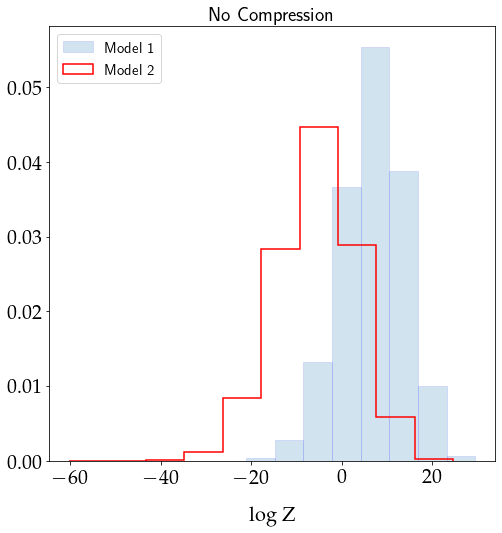

In [28]:
plt.figure(figsize = (8,8))
plt.title('No Compression', fontsize = fontSize)
plt.hist(evi_1_full, density = True, edgecolor='b', linewidth=0.5, alpha = 0.2, label = 'Model 1')
plt.hist(evi_2_full, density = True, edgecolor='r', linewidth=1.5, histtype='step', label = 'Model 2')
plt.xlabel(r'$\textrm{log Z}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

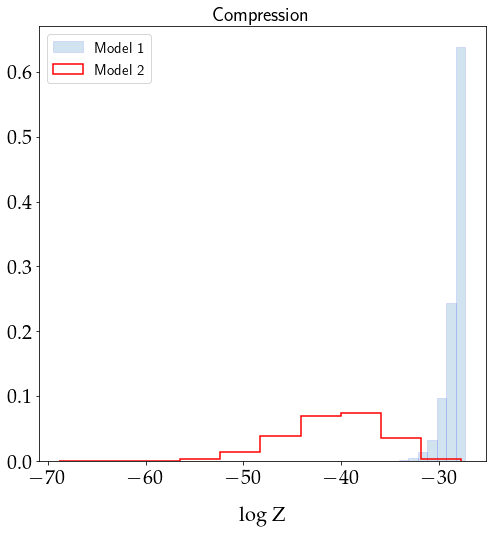

In [29]:
plt.figure(figsize = (8,8))
plt.title('Compression', fontsize = fontSize)
plt.hist(evi_1_comp_alan, density = True, edgecolor='b', linewidth=0.5, alpha = 0.2, label = 'Model 1')
plt.hist(evi_2_comp_alan, density = True, edgecolor='r', linewidth=1.5, histtype='step', label = 'Model 2')
plt.xlabel(r'$\textrm{log Z}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

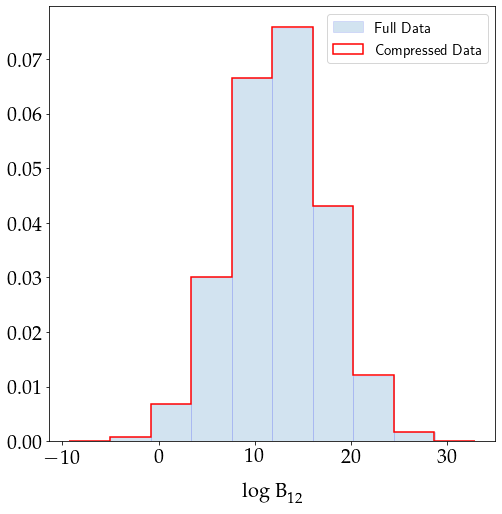

In [30]:
plt.figure(figsize = (8,8))
plt.hist(record_full, density = True, edgecolor='b', linewidth=0.5, label = 'Full Data', alpha = 0.2)
plt.hist(record_comp_alan, density = True, edgecolor='r', linewidth=1.5, label = 'Compressed Data', histtype='step')
plt.xlabel(r'$\textrm{log B}_{12}$', fontsize = fontSize, labelpad=20)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

### Full data

In [31]:
np.mean(record_full), np.std(record_full)

(12.554439690825697, 4.949707072167047)

### Alan

In [32]:
np.mean(record_comp_alan), np.std(record_comp_alan)

(12.538222715508116, 4.9431740074336545)